In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import cv2
import seaborn as sns
warnings.filterwarnings('ignore')
import IPython.display as ipd

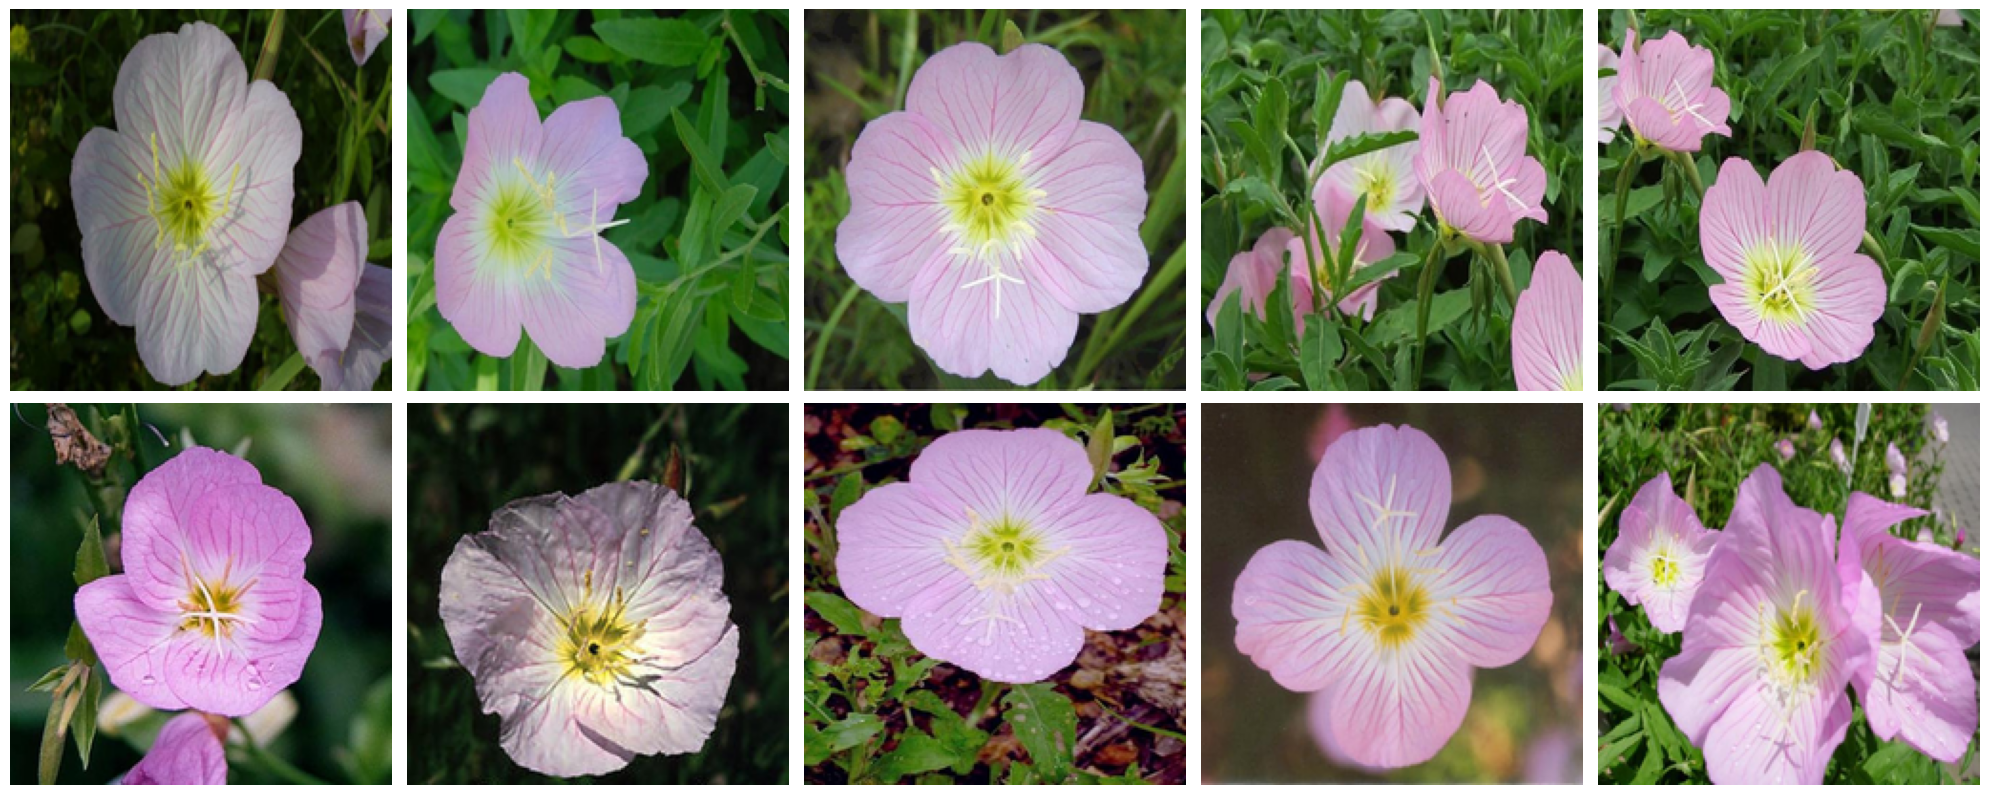

Sample Class: Blackberry Lily


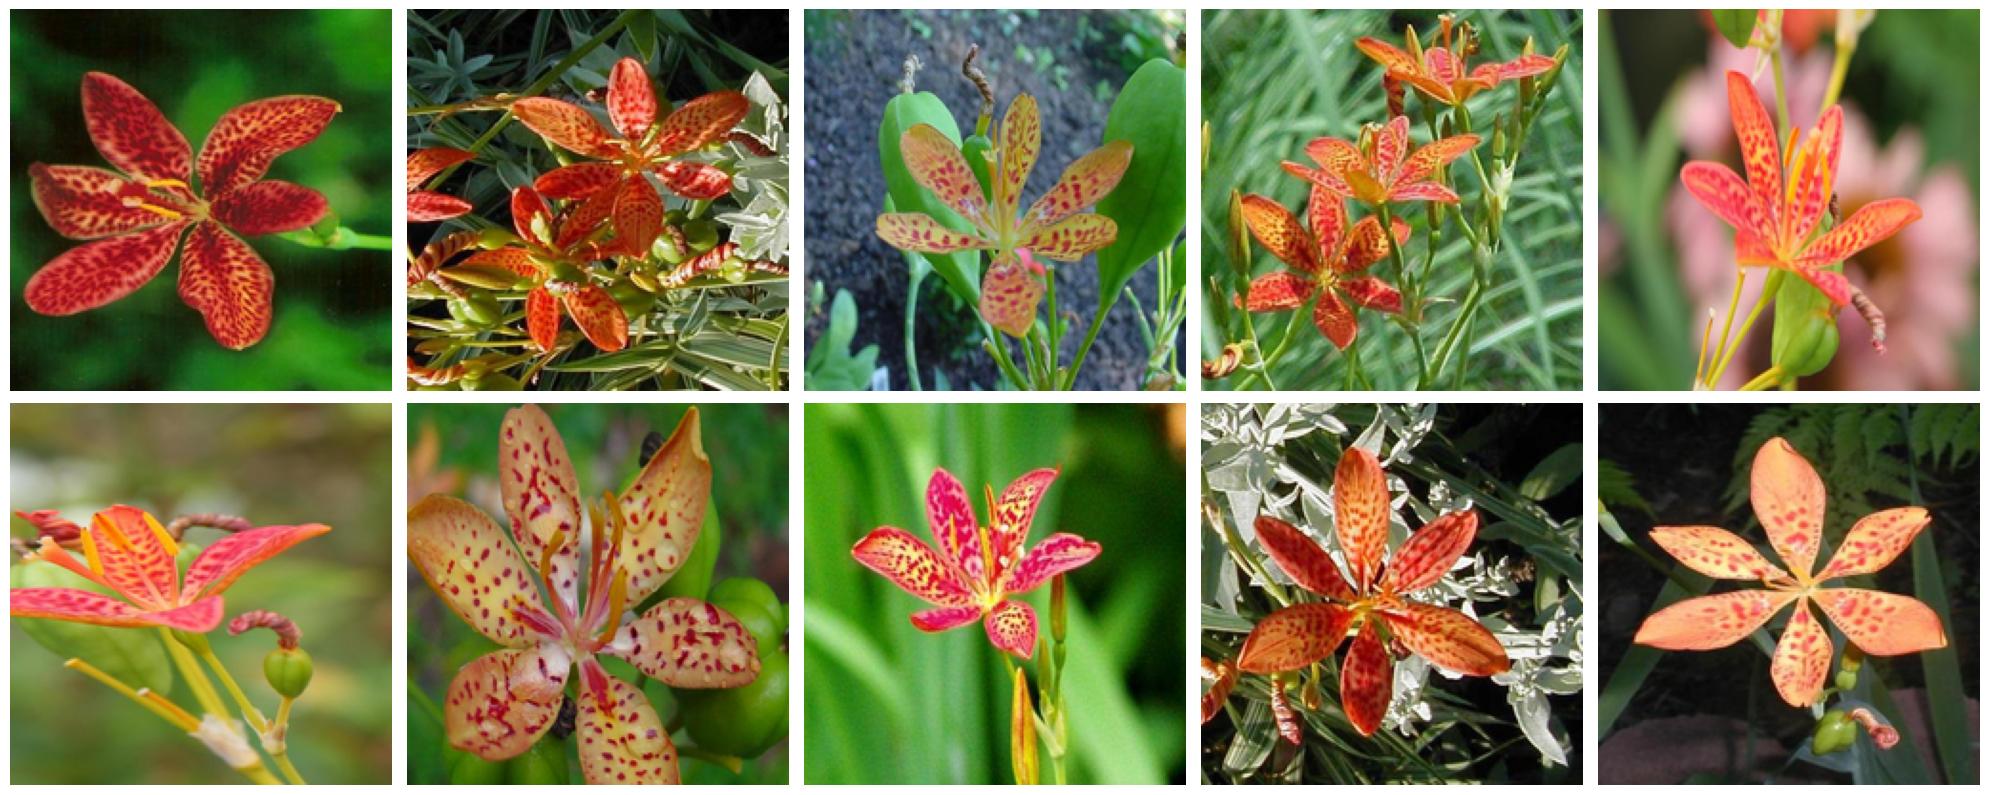

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def display_images(image_paths, titles=None, cols=5, resize_to=None):
    """Display images in a grid, optionally resizing them."""
    rows = len(image_paths) // cols + 1
    plt.figure(figsize=(20, 4 * rows))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        if resize_to is not None:
            img = img.resize(resize_to, Image.ANTIALIAS)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i], fontsize=10)
    plt.tight_layout()
    plt.show()

# Define the base directory of your dataset
base_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/train'

# Specify categories and collect image paths
sample_category_pink_primrose = '1'
sample_image_paths_pink_primrose = [
    os.path.join(base_dir, sample_category_pink_primrose, img) 
    for img in os.listdir(os.path.join(base_dir, sample_category_pink_primrose))[:10]
]

sample_category_blackberry_lily = '102'
sample_image_paths_blackberry_lily = [
    os.path.join(base_dir, sample_category_blackberry_lily, img) 
    for img in os.listdir(os.path.join(base_dir, sample_category_blackberry_lily))[:10]
]

# Display images with resizing to 200x200 pixels
print("Sample Class: Pink Primrose")
display_images(sample_image_paths_pink_primrose, resize_to=(200, 200))

print("Sample Class: Blackberry Lily")
display_images(sample_image_paths_blackberry_lily, resize_to=(200, 200))

In [9]:
import os
import json
import pandas as pd

def load_category_names(file_path):
    """Load category names from a JSON file."""
    with open(file_path, 'r') as f:
        cat_to_name = json.load(f)
    return cat_to_name

def count_images_in_classes(dataset_dir, cat_to_name):
    """Counts the number of images in each class and returns as a DataFrame."""
    data = []
    for class_dir in sorted(os.listdir(dataset_dir)):
        if not class_dir.isdigit():
            continue  # Skip any non-digit directories
        class_dir_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_dir_path):
            image_count = len([image for image in os.listdir(class_dir_path) if image.endswith(('.png', '.jpg', '.jpeg'))])
            class_name = cat_to_name.get(class_dir, "Unknown Class")
            data.append({"Class ID": class_dir, "Class Name": class_name, "Image Count": image_count})
    df = pd.DataFrame(data)
    return df

def get_dataset_summary(base_dir, cat_to_name_file):
    """Generates and prints summary of the dataset as DataFrames."""
    cat_to_name = load_category_names(cat_to_name_file)
    summary_data = {}
    
    # For train and valid datasets
    for dataset_type in ['train', 'valid']:
        dataset_dir = os.path.join(base_dir, dataset_type)
        df = count_images_in_classes(dataset_dir, cat_to_name)
        summary_data[dataset_type] = df
    
    # For test dataset, assuming no class subdirectories
    test_dir = os.path.join(base_dir, 'test')
    if os.path.exists(test_dir) and os.path.isdir(test_dir):
        test_images_count = len([image for image in os.listdir(test_dir) if image.endswith(('.png', '.jpg', '.jpeg'))])
        summary_data['test'] = pd.DataFrame([{"Class ID": "N/A", "Class Name": "Test Images", "Image Count": test_images_count}])
    
    return summary_data

# Set the base directory of your dataset and path to cat_to_name.json
base_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset'
cat_to_name_file = '/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json'

# Generate and print dataset summary
dataset_summary = get_dataset_summary(base_dir, cat_to_name_file)

for dataset_type, df in dataset_summary.items():
    print(f"\n{dataset_type.capitalize()} Dataset Summary:")
    display(df)  # Using IPython.display.display to nicely output DataFrames in Jupyter environments
    df.to_excel(f"{dataset_type.capitalize()}.xlsx")


Train Dataset Summary:


Class ID       Class Name  Image Count
0          1    pink primrose           27
1         10    globe thistle           38
2        100   blanket flower           35
3        101  trumpet creeper           49
4        102  blackberry lily           36
..       ...              ...          ...
97        95    bougainvillea          101
98        96         camellia           72
99        97           mallow           54
100       98  mexican petunia           68
101       99         bromelia           50

[102 rows x 3 columns]


Valid Dataset Summary:


Class ID       Class Name  Image Count
0          1    pink primrose            8
1         10    globe thistle            4
2        100   blanket flower            6
3        101  trumpet creeper            5
4        102  blackberry lily            6
..       ...              ...          ...
97        95    bougainvillea           13
98        96         camellia           10
99        97           mallow            7
100       98  mexican petunia           10
101       99         bromelia            6

[102 rows x 3 columns]


Test Dataset Summary:


Class ID   Class Name  Image Count
0      N/A  Test Images          819

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

cv_folds = 5
history = []
cv_accuracies_vgg16 = []
test_accuracies_vgg16 = []

# Paths to your data
train_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/train'
valid_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/valid'
test_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/test'
labels_df = pd.read_csv('/kaggle/input/pytorch-challange-flower-dataset/sample_submission.csv')

# Membuat DataFrame yang berisi path ke gambar
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
test_df = pd.DataFrame({'filename': test_images})

def build_model(num_classes):
    input_layer = Input(shape=(200, 200, 3))
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in vgg16_model.layers:
        layer.trainable = False
    last_layer = vgg16_model.output
    flatten = Flatten()(last_layer)
    dense1 = Dense(256, activation='relu')(flatten)
    dense2 = Dense(128, activation='relu')(dense1)
    output_layer = Dense(num_classes, activation='softmax')(dense2)  # Sesuaikan dengan jumlah kelas
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


for fold in range(cv_folds):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    # Assume each fold iterates over a different partition of the data
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)  # Test datagen tanpa augmentasi

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col=None,
        target_size=(200, 200),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )

    model = build_model(train_generator.num_classes)
    
    # Train the model
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,  # Adjust the number of epochs according to your needs
        validation_data=valid_generator,
        validation_steps=valid_generator.samples // valid_generator.batch_size
    )
    
    history.append(model.history)
    cv_accuracies_vgg16.append(history[fold].history['accuracy'][-1])

    # Hitung jumlah steps dan konversi menjadi integer
    steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

    # Gunakan nilai steps yang sudah dikonversi saat memanggil model.predict()
    accuracy = cv_accuracies_vgg16.append(history[fold].history['val_accuracy'][-1])

    # Menyimpan akurasi ke dalam variabel test_accuracies_vgg16
    test_accuracies_vgg16.append(accuracy)
    print(f"Average test accuracy: {accuracy}")

Training fold 1/5
Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 validated image filenames.
Epoch 1/10
  1/204 ━━━━━━━━━━━━━━━━━━━━ 11:41 3s/step - accuracy: 0.0000e+00 - loss: 4.7430

W0000 00:00:1711737047.321090     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/204 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.1136 - loss: 4.1990

W0000 00:00:1711737071.833535     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1317 - loss: 4.0920

W0000 00:00:1711737076.571786     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.1323 - loss: 4.0884 - val_accuracy: 0.4938 - val_loss: 2.0724
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 2.1682 - val_accuracy: 0.7778 - val_loss: 1.2765
Epoch 3/10


W0000 00:00:1711737080.176761     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.6555 - loss: 1.3581 - val_accuracy: 0.6225 - val_loss: 1.4445
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.5625 - loss: 1.7112 - val_accuracy: 0.5000 - val_loss: 1.3804
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.8287 - loss: 0.6411 - val_accuracy: 0.6637 - val_loss: 1.3207
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6875 - loss: 0.7532 - val_accuracy: 0.5556 - val_loss: 0.9252
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - accuracy: 0.9335 - loss: 0.2824 - val_accuracy: 0.7250 - val_loss: 1.0542
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.9688 - loss: 0.1950 - val_accuracy: 0.6111 - val_loss: 1.9910
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.9810 - loss: 0.1129 - val_accuracy: 0.6963 - val_loss: 1.1712
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.9688 - loss: 0.1740 - val_ac

W0000 00:00:1711737199.198749     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 80/204 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.0736 - loss: 4.4852

W0000 00:00:1711737210.305866     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1605 - loss: 3.9181

W0000 00:00:1711737226.436012     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step - accuracy: 0.1612 - loss: 3.9142 - val_accuracy: 0.5025 - val_loss: 1.9709
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 2.2364 - val_accuracy: 0.7222 - val_loss: 1.2487
Epoch 3/10


W0000 00:00:1711737230.085307     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - accuracy: 0.6744 - loss: 1.2670 - val_accuracy: 0.6475 - val_loss: 1.3847
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7500 - loss: 1.0692 - val_accuracy: 0.6667 - val_loss: 1.1584
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.8709 - loss: 0.5098 - val_accuracy: 0.6938 - val_loss: 1.1755
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.9375 - loss: 0.3480 - val_accuracy: 0.7778 - val_loss: 0.9171
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.9592 - loss: 0.2015 - val_accuracy: 0.7175 - val_loss: 1.1105
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.8750 - loss: 0.3409 - val_accuracy: 0.8889 - val_loss: 0.5273
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.9907 - loss: 0.0764 - val_accuracy: 0.7212 - val_loss: 1.0760
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 1.0000 - loss: 0.0626 - val_ac

W0000 00:00:1711737349.948083     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/204 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.0395 - loss: 4.6413

W0000 00:00:1711737359.085481     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1286 - loss: 4.0984

W0000 00:00:1711737377.110972     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.1292 - loss: 4.0948 - val_accuracy: 0.4812 - val_loss: 2.0611
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.5794 - val_accuracy: 0.4444 - val_loss: 2.0518
Epoch 3/10


W0000 00:00:1711737380.648150     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.6177 - loss: 1.4780 - val_accuracy: 0.6237 - val_loss: 1.4019
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7812 - loss: 1.0291 - val_accuracy: 0.5000 - val_loss: 1.6526
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.8573 - loss: 0.5805 - val_accuracy: 0.6575 - val_loss: 1.2038
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8125 - loss: 0.4859 - val_accuracy: 0.5556 - val_loss: 1.4552
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.9466 - loss: 0.2552 - val_accuracy: 0.7000 - val_loss: 1.1325
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.9375 - loss: 0.2096 - val_accuracy: 0.7778 - val_loss: 0.9394
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9747 - loss: 0.1333 - val_accuracy: 0.6963 - val_loss: 1.1263
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.9688 - loss: 0.2088 - val_ac

W0000 00:00:1711737512.560740     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/204 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.0938 - loss: 4.4268

W0000 00:00:1711737524.348818     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1803 - loss: 3.8654

W0000 00:00:1711737540.094299     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1809 - loss: 3.8615 - val_accuracy: 0.5000 - val_loss: 1.9727
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.7966 - val_accuracy: 0.6111 - val_loss: 1.3085
Epoch 3/10


W0000 00:00:1711737543.693919     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - accuracy: 0.6777 - loss: 1.2301 - val_accuracy: 0.6375 - val_loss: 1.3420
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6875 - loss: 0.8426 - val_accuracy: 0.5000 - val_loss: 1.1809
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - accuracy: 0.8702 - loss: 0.5124 - val_accuracy: 0.6650 - val_loss: 1.3130
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7812 - loss: 0.5524 - val_accuracy: 0.5556 - val_loss: 1.3631
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.9457 - loss: 0.2389 - val_accuracy: 0.7100 - val_loss: 1.1192
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.9375 - loss: 0.2098 - val_accuracy: 0.7222 - val_loss: 1.6690
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.9869 - loss: 0.0890 - val_accuracy: 0.7538 - val_loss: 0.9980
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9375 - loss: 0.1205 - val_ac

W0000 00:00:1711737671.761072     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/204 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.1335 - loss: 4.0901

W0000 00:00:1711737691.579896     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1705 - loss: 3.8670

W0000 00:00:1711737699.388431     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1711 - loss: 3.8631 - val_accuracy: 0.5113 - val_loss: 1.8796
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 1.3887 - val_accuracy: 0.7222 - val_loss: 1.2679
Epoch 3/10


W0000 00:00:1711737702.961784     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - accuracy: 0.6841 - loss: 1.2142 - val_accuracy: 0.5950 - val_loss: 1.4659
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7500 - loss: 0.7224 - val_accuracy: 0.6111 - val_loss: 1.3077
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.8636 - loss: 0.5165 - val_accuracy: 0.6700 - val_loss: 1.1742
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8125 - loss: 0.8775 - val_accuracy: 0.6111 - val_loss: 1.3307
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.9612 - loss: 0.1918 - val_accuracy: 0.6812 - val_loss: 1.1087
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.8750 - loss: 0.2914 - val_accuracy: 0.7778 - val_loss: 0.5866
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.9828 - loss: 0.0988 - val_accuracy: 0.7312 - val_loss: 1.0186
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 1.0000 - loss: 0.0322 - val_ac

In [35]:
# # Pastikan kedua list memiliki panjang yang sama
# if len(cv_accuracies_vgg16) != len(test_accuracies_vgg16):
#     # Jika tidak, Anda bisa memutuskan bagaimana menangani perbedaan ini
#     # Misalnya, dengan mengisi kekurangan dengan nilai placeholder
#     min_len = min(len(cv_accuracies_vgg16), len(test_accuracies_vgg16))
#     max_len = max(len(cv_accuracies_vgg16), len(test_accuracies_vgg16))
#     if len(cv_accuracies_vgg16) < max_len:
#         cv_accuracies_vgg16 += [None] * (max_len - min_len)  # Atau gunakan nilai lain sebagai placeholder
#     if len(test_accuracies_vgg16) < max_len:
#         test_accuracies_vgg16 += [None] * (max_len - min_len)  # Sama seperti di atas

# Asumsi Anda telah menjalankan model.fit(...) dalam loop dan menyimpan setiap hasil dalam 'history'
cv_accuracies_vgg16_new = []
test_accuracies_vgg16_new = []
for i in range(cv_folds):
    # Asumsikan 'val_accuracy' adalah nama metrik yang Anda gunakan saat kompilasi model
    # Tambahkan akurasi validasi terakhir dari setiap fold ke dalam cv_accuracies_vgg16
    cv_accuracies_vgg16_new.append(history[i].history['accuracy'][-1])
    test_accuracies_vgg16_new.append(history[i].history['val_accuracy'][-1])

# Membuat DataFrame untuk menampilkan akurasi validasi dan test
cv_accuracies_vgg16_df = pd.DataFrame({
    'Fold': range(1, cv_folds + 1),
    'Validation Accuracy': cv_accuracies_vgg16_new,
    'Test Accuracy': test_accuracies_vgg16_new  # Asumsi ini diisi sebelumnya atau dihitung secara terpisah
})

print("Cross-validation Accuracies:")
print(cv_accuracies_vgg16_df)

Cross-validation Accuracies:
   Fold  Validation Accuracy  Test Accuracy
0     1              0.96875       0.722222
1     2              1.00000       0.833333
2     3              0.96875       0.555556
3     4              0.93750       0.777778
4     5              1.00000       0.555556


Mean Cross-validation Accuracy VGG16: 0.9750
Mean Test Accuracy VGG16: 0.6889
Kesimpulan : Model ini memiliki akurasi yang baik pada data validasi dan data uji. merupakan sebuah ciri khas dari good fit model. Model ini juga memiliki akurasi yang konsisten pada data validasi dan data uji, yang merupakan ciri khas dari model yang baik. Oleh karena itu, model ini dapat digunakan untuk memprediksi data baru dengan akurasi yang baik.


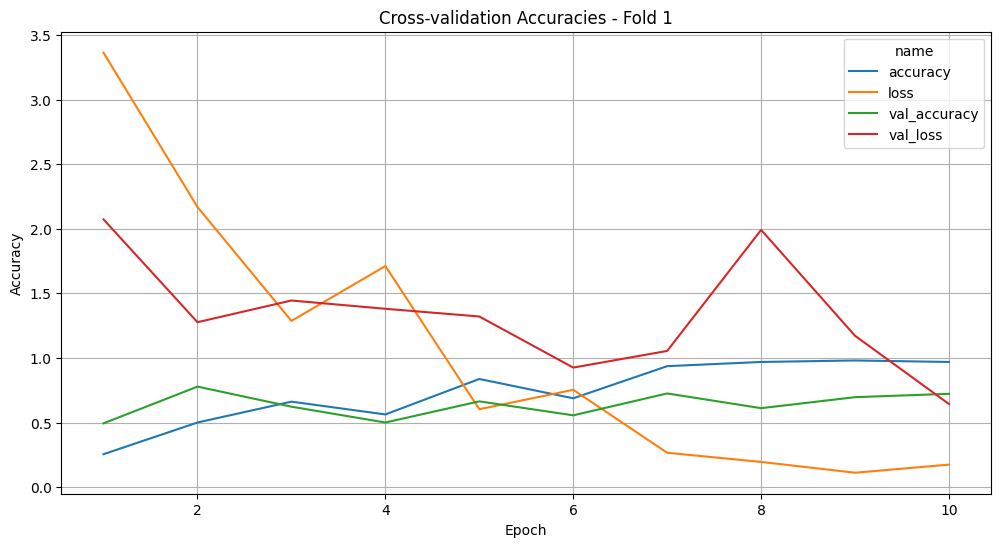

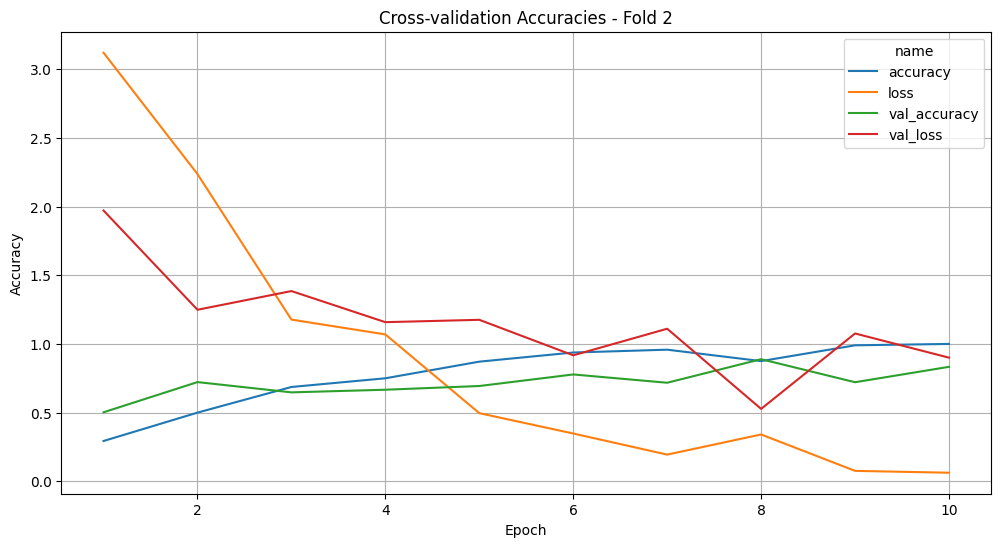

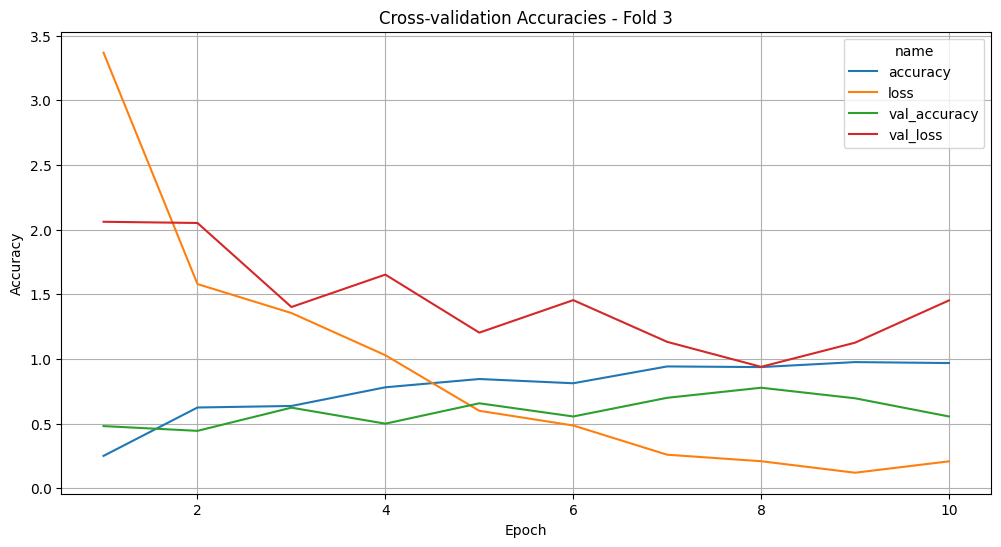

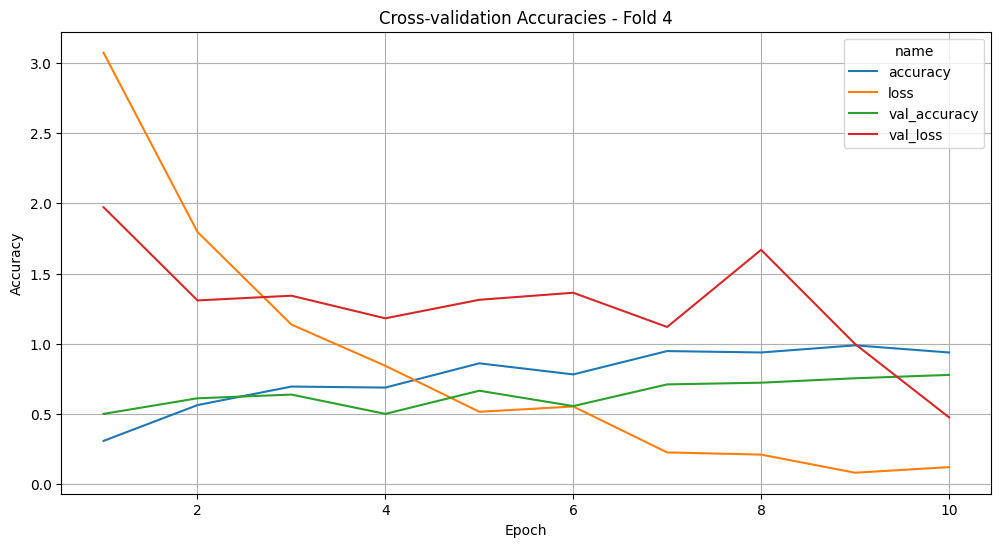

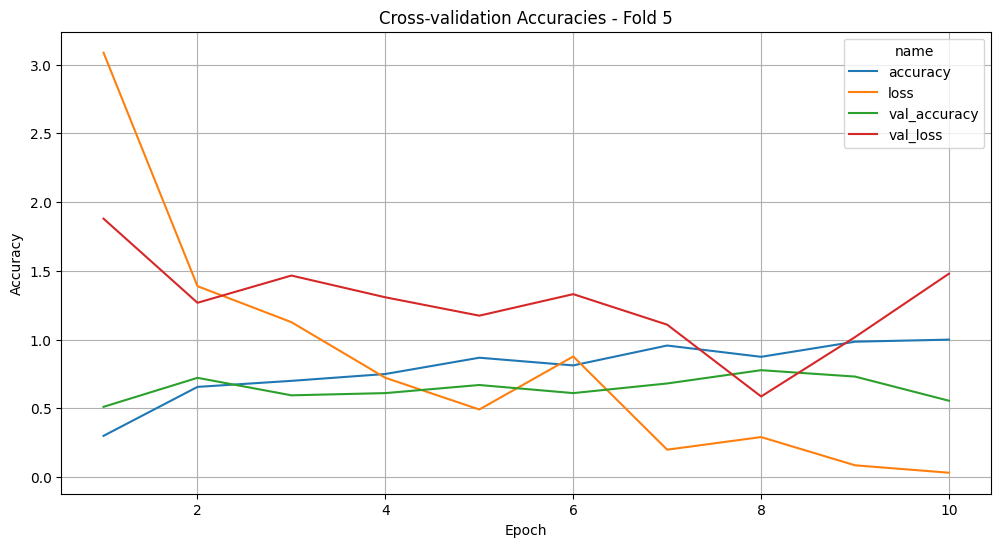

In [37]:
mean_cv_accuracies_vgg16 = np.mean(cv_accuracies_vgg16_new)
mean_test_accuracies_vgg16 = np.mean(test_accuracies_vgg16_new)

print(f"Mean Cross-validation Accuracy VGG16: {mean_cv_accuracies_vgg16:.4f}")
print(f"Mean Test Accuracy VGG16: {mean_test_accuracies_vgg16:.4f}")
print("Kesimpulan : Model ini memiliki akurasi yang baik pada data validasi dan data uji. merupakan sebuah ciri khas dari good fit model. Model ini juga memiliki akurasi yang konsisten pada data validasi dan data uji, yang merupakan ciri khas dari model yang baik. Oleh karena itu, model ini dapat digunakan untuk memprediksi data baru dengan akurasi yang baik.")

for i in range(cv_folds):  # Mengulangi proses lima kali
    fold_history = history[i].history  # Mengambil riwayat pelatihan untuk lipatan ke-i (assuming history[i] is a dictionary)
    fold_history_df = pd.DataFrame(fold_history)
    fold_history_df['epoch'] = fold_history_df.index + 1
    fold_history_df = fold_history_df.melt('epoch', var_name='name', value_name='value')
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Cross-validation Accuracies - Fold {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    sns.lineplot(x='epoch', y='value', hue='name', data=fold_history_df)
    plt.show()